# Systems Identification Model Fitting

Fit a Systems Identification model off based off of this [specification](https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ) and [spec](https://hackmd.io/XVaejEw-QaCghV1Tkv3eVQ) with data obtained in [data_acquisition.ipynb](data/data_acquisition.ipynb). 

#### Process changes and decision points
* Create differenced linear regressor model for refining data formatting
* Fit VAR model off of differenced states with Yeo-Johnson power transformation
* Implemented coordinate transformations 
* Created inverse transformations
* Fit one step forward VAR model that takes the difference between local arbitrager values and observed values and forcasts the errors within the coordinate transformation state.
* Fit VARMAX model with exogenous signal - error between redemption price and rai market price - retrain after every timestep 
* Compare VARMAX vs VAR model (we chose VARMAX with an exogenous signal)
* VARMAX is too slow to retrain at each time step (25x slower than VAR). To determine which model performs better, we created a [validation notebook](VAR_vs_VARMAX_evaluation.ipynb)
* Refactor to functions for deployment
* Add back Yeo-Johnson power transformation
* Move from arbitrageur to exponentially weighted moving average of actual data
* Swept alpha of exponentially weighted moving average and found that a VAR(15) with an alpha of 0.8 performed best. 


## Analyze and Prepare Data

In [235]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import math
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VARMAX
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")

os.chdir('..')
states = pd.read_csv('states.csv')
del states['Unnamed: 0']
states.head()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs,collateral,debt,ETH Price (OSM)
0,0.000858,3.051840,12388143.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005443,11977.048864,1.389236e+07,2.601571e+07,1249.4226,293469.366076,3521.749280
1,0.000858,3.051840,12387897.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005450,12025.302340,1.383645e+07,2.601571e+07,1249.4226,293469.366076,3484.967617
2,0.000869,3.060763,12387633.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3509.940000
3,0.000870,3.051668,12387345.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3438.463957
4,0.000875,3.043224,12387095.0,0.0,2.629407e+07,1.157921e+32,229903.041060,583.0,0.978704,0.999998,0.99998,3.005472,12080.165571,1.377424e+07,2.598521e+07,1249.4226,293469.366076,3464.125574


In [236]:
# add additional state variables
states['RedemptionPriceinEth'] = states['RedemptionPrice'] / states['ETH Price (OSM)']
states['RedemptionPriceError'] = states['RedemptionPrice'] - states['marketPriceUsd']

### Systems identification steps:
1. Calculate optimal state from APT model (updated to exponential weighted moving average of the real data)

2. Perform a coordinate transformation of data 

3. Difference the local coordinate from the observed to get error

4. Perform a Yeo-Johnson power transformation
<!-- 4. Train VARMAX the errors + exogenous signal[s]
 -->
5. Train a VAR(15) model

6. One step forecast

7. Invert the Yeo-Johnson power transformation

8. Convert forecasted values back from coordinate system 

9. Add forecasted values to previous state to get new state 


### Mapping of specification states to data

#### Initial vector 
The quantity state variables of the system are as value, mathematical notation, and Graph and Big Query field names from [data_acquisition.ipynb](data/data_acquisition.ipynb).
* ETH in collateral = $Q$ = collateral 
* ETH in Uniswap = $R_{ETH}$ = EthInUniswap
* RAI in Uniswap = $R_{RAI}$ = RaiInUniswap 
* RAI drawn from SAFEs = $D$ = RaiDrawnFromSAFEs


<!-- (GlobalDebt won't equal total supply (create graphics around?)) -->

The metric state variables of the system are:

* Market Price of RAI in ETH = $p_{E/R} > 0$   = marketPriceEth
* Market Price of RAI in USD =  $p_{U/R} > 0$ =  marketPriceUsd
* Market Price of ETH in USD = $p_{U/E} > 0$ = ETH Price (OSM)

The metric control variables of the system are:

* Redemption Price of RAI in USD = $p^r_{U/R} > 0$ = RedemptionPrice
* Redemption Price of RAI in ETH = $p^r_{E/R} > 0$ = RedemptionPriceinEth 

The system parameters are:
* Liquidation Ratio = $\bar{L} > 0$ = 1.45
* SAFE Debt Ceiling = $\bar{D} > 0$ = globalDebtCeiling
* Uniswap Fee =  $\phi_U \in (0,1)$  = 0.003 
* Gas Costs = $\bar{C}_{gas} \geq 0$ = 100e-9, # 100 gwei

The aggregate flow variables are:
* Collateral added or removed =  $q \in \mathbb{R}$ (ETH)
* SAFE Debt drawn or repaid = $d \in \mathbb{R}$   (RAI)
* Uniswap RAI bought or sold = $r \in \mathbb{R}$   (RAI)
* Uniswap ETH bought or sold = $z \in \mathbb{R}$   (ETH)


### Model Formulation


There is an admissible action set of vectors:
(Graph values)
* ETH in collateral = $Q$ = collateral
* ETH in Uniswap = $R_{ETH}$ reserve1
* RAI in Uniswap = $R_{RAI}$ = reserve0 
* RAI drawn from SAFEs = $D$ = erc20CoinTotalSupply



Action vector: $\vec{u} = (\Delta Q, \Delta R_{ETH}, \Delta R_{RAI}, \Delta D)$

Admissible action set: $\vec{u} \in \mathcal{U}$

Optimal Action Vector: $\vec{u^*} = (Q^*, R_{ETH}^*, \Delta R_{RAI}^*, \Delta D^*)$


In [237]:
# define constants (will come from cadCAD model but added here for calculations)
params = {
    'liquidation_ratio': 1.45,
    'debt_ceiling': 1e9,
    'uniswap_fee': 0.003,
    'arbitrageur_considers_liquidation_ratio': True,
}


## Create Arbtrageur data vector $u^*$

In [238]:
def get_aggregated_arbitrageur_decision(params, state):

    # This Boolean indicates whether or not the arbitrageur is rationally considering 
    # borrowing to the liquidation ratio limit. If TRUE, arbitrage opportunities are less
    # frequent when RAI is expensive and more frequent when RAI is cheap. If FALSE, only 
    # the difference in market and redemption prices (net of Uniswap fee) matters for trading, 
    # which may conform more to individual trader expectations and behavior.
    consider_liquidation_ratio = params['arbitrageur_considers_liquidation_ratio']
    
    # These are the states of the SAFE balances in aggregate & its fixed parameters
    total_borrowed = state['SAFE_Debt'] # D
    total_collateral = state['SAFE_Collateral'] # Q
    liquidation_ratio = params['liquidation_ratio']
    debt_ceiling = params['debt_ceiling']


    # These are the states of the Uniswap secondary market balances and its fee
    RAI_balance = state['RAI_balance'] # R_Rai
    ETH_balance = state['ETH_balance'] # R_Eth
    uniswap_fee = params['uniswap_fee']

    # These are the prices of RAI in USD/RAI for SAFE redemption and the market price oracle, resp.
    redemption_price = state['target_price'] # $p^r_{U/R}
    market_price = state['market_price'] # p_{U/R} > 0
    
    # This is the price of ETH in USD/ETH
    eth_price = state['eth_price'] # p_{U/E}

        
    # These functions define the optimal borrowing/repayment decisions of the aggregated arbitrageur
    def g1(RAI_balance, ETH_balance, uniswap_fee, liquidation_ratio, redemption_price):
        return ((eth_price * RAI_balance * ETH_balance * (1 - uniswap_fee)) / (liquidation_ratio * redemption_price)) ** 0.5

    def g2(RAI_balance, ETH_balance, uniswap_fee, liquidation_ratio, redemption_price):
        return (RAI_balance * ETH_balance * (1 - uniswap_fee) * liquidation_ratio * (redemption_price / eth_price)) ** 0.5

    # This Boolean resolves to TRUE if the agg. arb. acts this timestep when RAI is expensive 
    # on the secondary market
    expensive_RAI_on_secondary_market = \
        redemption_price < ((1 - uniswap_fee) / liquidation_ratio) * market_price  \
        if consider_liquidation_ratio \
        else redemption_price < (1 - uniswap_fee) * market_price
        
    # This Boolean resolves to TRUE if the agg. arb. acts this timestep when RAI is cheap 
    # on the secondary market
    cheap_RAI_on_secondary_market = \
        redemption_price > (1 / ((1 - uniswap_fee) * liquidation_ratio)) * market_price  \
        if consider_liquidation_ratio \
        else redemption_price > (1 / (1 - uniswap_fee)) * market_price

    if expensive_RAI_on_secondary_market:
        '''
        Expensive RAI on Uni:
        (put ETH from pocket into additional collateral in SAFE)
        draw RAI from SAFE -> Uni
        ETH from Uni -> into pocket
        '''

        _g1 = g1(RAI_balance, ETH_balance, uniswap_fee,
                 liquidation_ratio, redemption_price)
        d = (_g1 - RAI_balance) / (1 - uniswap_fee) # should be \geq 0
        q = ((liquidation_ratio * redemption_price) /
                     eth_price) * (total_borrowed + d) - total_collateral # should be \geq 0
        z = -(ETH_balance * d * (1 - uniswap_fee)) / \
            (RAI_balance + d * (1 - uniswap_fee)) # should be leq 0
        r = d # should be \geq 0
        
    elif cheap_RAI_on_secondary_market:
        '''
        Cheap RAI on Uni:
        ETH out of pocket -> Uni
        RAI from UNI -> SAFE to wipe debt
        (and collect collateral ETH from SAFE into pocket)
        '''

        _g2 = g2(RAI_balance, ETH_balance, uniswap_fee,
                 liquidation_ratio, redemption_price)
        z = (_g2 - ETH_balance) / (1 - uniswap_fee) # should be \geq 0
        r = -(RAI_balance * z * (1 - uniswap_fee)) / \
            (ETH_balance + z * (1 - uniswap_fee)) # should be \leq 0
        d = r # should be \leq 0
        q = ((liquidation_ratio * redemption_price /
             eth_price) * (total_borrowed + d) - total_collateral) # should be \leq 0
    else:
        pass

    return {
        'q' : q,
        'd' : d,
        'r' : r,
        'z' : z
    }

In [239]:
# UPDATED: We will use an exponentially weighted moving average instead of this arbitrageur logic

# # subset state variables for arbitrageur vector
# state_subset = states[['marketPriceUsd','RedemptionPrice','ETH Price (OSM)','collateral',
#                        'EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']]
# # map state data to arbitrageur vector fields 
# state_subset.columns = ['market_price','target_price','eth_price','SAFE_Collateral',
#                        'ETH_balance','RAI_balance','SAFE_Debt']

# # create list of u^* vectors
# values = []

# # iterate through real data to create u^* and save to values
# for i in range(0,len(state_subset)):
#     values.append(get_aggregated_arbitrageur_decision(params,state_subset.loc[i]))
    
# # create historic u^* dataframe
# local = pd.DataFrame(values)
# local.columns = ['Q','D','Rrai','Reth']
# local.head()

In [240]:
# subset state variables for arbitrageur vector
state_subset = states[['collateral','RaiDrawnFromSAFEs','RaiInUniswap','EthInUniswap']]

# map state data to vector fields 
state_subset.columns = ['Q','D','Rrai','Reth']

# alpha is the smoothing factor
local = state_subset.ewm(alpha=0.8).mean()
local

,Q,D,Rrai,Reth
0,1249.422600,2.601571e+07,1.389236e+07,11977.048864
1,1249.422600,2.601571e+07,1.384577e+07,12017.260094
2,1249.422600,2.599152e+07,1.383046e+07,12030.502525
3,1249.422600,2.598687e+07,1.382752e+07,12033.049146
4,1249.422600,2.598554e+07,1.378488e+07,12070.754352
...,...,...,...,...
1942,18.086319,3.383805e+03,7.636681e+02,1.509233
1943,17.131152,3.115513e+03,7.942806e+02,1.436701
1944,16.940119,3.061855e+03,8.004031e+02,1.422195
1945,16.901912,3.051123e+03,8.016276e+02,1.419294


## Coordinate Transformations 

1. $\alpha := \frac{d}{\bar{D}}$

Constraint: $\bar{D} \geq D + d$

$ C_0 := \frac{p^r_{U/R}}{p_{U/E}}\bar{L} > 0$

$ C_0 D - Q =: C_1.$

2. $\beta := \frac{q - C_0 d}{C_1}$

3. $\gamma := \frac{r}{R_{RAI}}$

4. $\delta := \frac{z}{R_{ETH}}$


## Inverse Transformations

1. $d^* = \alpha * \bar{D}$

2. $q^* = C_0 * \bar{D} * \alpha + C_1 * \beta$

3. $r^* = \gamma * {R_{RAI}}$

4. $z^* = \delta * {R_{ETH}}$


In [241]:
# function to create coordinate transformations
def coordinate_transformations(params,df,Q,R_eth,R_rai,D,RedemptionPrice,EthPrice):
    '''
    Description:
    Function that takes in pandas dataframe and the names of columns
    
    Parameters:
    df: pandas dataframe containing states information
    Q: dataframe column name
    R_eth: dataframe column name
    R_rai: dataframe column name
    D: dataframe column name
    RedemptionPrice: dataframe column name
    EthPrice: dataframe column name

    Returns: Pandas dataframe with alpha, beta, gamma, delta transformed values
    
    Example:
    
    coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]
    '''
    
    # Calculate alpha
    d = df[D].diff()
    d.fillna(0,inplace=True)
    df['d'] = d
    
    df['alpha'] = df['d'] / params['debt_ceiling']

    # calculate beta
    df['C_o'] = (df[RedemptionPrice]/states[EthPrice]) * params['liquidation_ratio']

    q = df[Q].diff()
    q.fillna(0,inplace=True)
    df['q'] = q


    df['C_1'] = (df['C_o'] * df[D]) - df[Q]

    df['beta'] = (df['q'] - (df['C_o']*df['d']))/ df['C_1']

    # calculate gamma
    r = df[R_rai].diff()
    r.fillna(0,inplace=True)
    df['r'] = r

    df['gamma'] = df['r']/df[R_rai]

    # calculate delta
    z = df[R_eth].diff()
    z.fillna(0,inplace=True)
    df['z'] = z

    df['delta'] = df['z']/df[R_eth]
    
    return df

In [242]:
# transform historical data 
transformed = coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]

transformed

,alpha,beta,gamma,delta
0,0.000000e+00,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000,-0.004041,0.004013
2,-3.000000e-05,0.001201,-0.000699,0.000696
3,0.000000e+00,0.000000,0.000000,0.000000
4,-5.000000e-07,0.000020,-0.003815,0.003848
...,...,...,...,...
1942,-1.646075e-06,0.108212,0.249397,-0.333334
1943,0.000000e+00,-0.000000,0.000000,0.000000
1944,0.000000e+00,-0.000000,0.000000,0.000000
1945,0.000000e+00,-0.000000,0.000000,0.000000


In [243]:
# add additional signals to arbitrageur state
local['RedemptionPrice'] = states['RedemptionPrice']
local['ETH Price (OSM)'] = states['ETH Price (OSM)']

local

,Q,D,Rrai,Reth,RedemptionPrice,ETH Price (OSM)
0,1249.422600,2.601571e+07,1.389236e+07,11977.048864,3.005443,3521.749280
1,1249.422600,2.601571e+07,1.384577e+07,12017.260094,3.005450,3484.967617
2,1249.422600,2.599152e+07,1.383046e+07,12030.502525,3.005465,3509.940000
3,1249.422600,2.598687e+07,1.382752e+07,12033.049146,3.005465,3438.463957
4,1249.422600,2.598554e+07,1.378488e+07,12070.754352,3.005472,3464.125574
...,...,...,...,...,...,...
1942,18.086319,3.383805e+03,7.636681e+02,1.509233,3.140000,1825.887144
1943,17.131152,3.115513e+03,7.942806e+02,1.436701,3.140000,1793.770282
1944,16.940119,3.061855e+03,8.004031e+02,1.422195,3.140000,1803.891149
1945,16.901912,3.051123e+03,8.016276e+02,1.419294,3.140000,1803.891149


In [244]:
# transform u*
transformed_arbitrageur = coordinate_transformations(params,local,'Q','Reth','Rrai',
                           'D','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]

transformed_arbitrageur

,alpha,beta,gamma,delta
0,0.000000e+00,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000,-0.003365,0.003346
2,-2.419355e-05,0.000968,-0.001107,0.001101
3,-4.652605e-06,0.000186,-0.000213,0.000212
4,-1.323500e-06,0.000053,-0.003093,0.003124
...,...,...,...,...
1942,-1.341458e-06,0.148292,0.200431,-0.240292
1943,-2.682915e-07,0.029727,0.038541,-0.050485
1944,-5.365830e-08,0.006036,0.007649,-0.010200
1945,-1.073166e-08,0.001209,0.001528,-0.002044


In [245]:
def create_transformed_errors(transformed_states,transformed_arbitrageur):
    '''
    Description:
    Function for taking two pandas dataframes of transformed states and taking the difference
    to produce an error dataframe. 
    
    Parameters:
    transformed_states: pandas dataframe with alpha, beta, gamma, and delta features
    transformed_arbitrageur: pandas dataframe with alpha, beta, gamma, and delta features

    Returns:
    error pandas dataframe and transformation object
    
    '''
    alpha_diff = transformed_states['alpha'] - transformed_arbitrageur['alpha']
    beta_diff = transformed_states['beta'] - transformed_arbitrageur['beta']
    gamma_diff = transformed_states['gamma'] - transformed_arbitrageur['gamma']
    delta_diff = transformed_states['delta'] - transformed_arbitrageur['delta']


    e_u = pd.DataFrame(alpha_diff)
    e_u['beta'] = beta_diff
    e_u['gamma'] = gamma_diff
    e_u['delta'] = delta_diff

    e_u = e_u.astype(float)
    
    return e_u

e_u = create_transformed_errors(transformed,transformed_arbitrageur)
e_u.head()

,alpha,beta,gamma,delta
0,0.000000e+00,0.000000,0.000000,0.000000
1,0.000000e+00,0.000000,-0.000676,0.000667
2,-5.806452e-06,0.000233,0.000408,-0.000404
3,4.652605e-06,-0.000186,0.000213,-0.000212
4,8.235004e-07,-0.000033,-0.000722,0.000724


In [246]:
e_u.describe()

,alpha,beta,gamma,delta
count,1.947000e+03,1947.000000,1947.000000,1947.000000
mean,-2.755948e-13,0.005452,-0.091925,-0.074291
std,8.318107e-05,0.706797,4.156794,3.379541
min,-6.070542e-04,-16.821328,-183.329159,-149.026011
25%,-1.144852e-05,-0.000458,-0.000638,-0.000682
50%,1.281023e-07,-0.000008,0.000000,-0.000003
75%,1.287181e-05,0.000388,0.000630,0.000668
max,7.434217e-04,25.887788,3.606227,3.343376


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

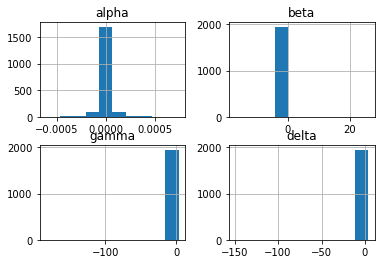

In [247]:
e_u.hist()

When data isn't normal (as is shown above), it is best practice to do a transformation. For our initial transformation, we will use the Yeo-Johnson power transformation. The Yeo-Johnson power transformation is used to stabilize variance, and make data more Gausian. The Yeo-Johnson is an extension of Box-Cox that allows for both zero and negative values(https://en.wikipedia.org/wiki/Power_transform). You could use any other type of normalization tranformation as well, whichever fits the data the best.

Scikit-learn has a great implementation of the transformer, which we will use below.

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

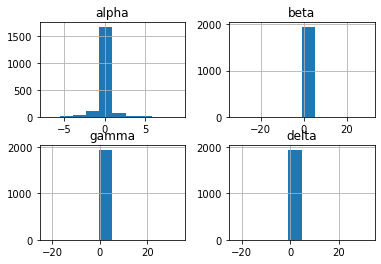

In [248]:
pt = PowerTransformer()
yeo= pd.DataFrame(pt.fit_transform(e_u),columns=e_u.columns)
yeo.hist()

In [249]:
# transform back into coordinate system
pt.inverse_transform(yeo)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -6.75761367e-04,
         6.66539218e-04],
       [-5.80645161e-06,  2.32674615e-04,  4.07970109e-04,
        -4.04494765e-04],
       ...,
       [ 5.36583042e-08, -6.03563019e-03, -7.64926883e-03,
         1.01999010e-02],
       [ 1.07316609e-08, -1.20858495e-03, -1.52751689e-03,
         2.04415023e-03],
       [ 2.14633222e-09, -2.42182239e-04, -3.05410074e-04,
         4.08997256e-04]])

The data looks a little better, but we can always experiment with additional techniques

In [250]:
def power_transformation(e_u):
    '''
    Definition:
    Function to perform a power transformation on the coordinate 
    transformed differenced data
    
    Parameters:
    e_u: Dataframe of coordinated transformed differenced data
    
    Required:
    import pandas as pd
    from sklearn.preprocessing import PowerTransformer
    
    Returns:
    Transformed dataframe and transformation object
    
    Example:
    transformed_df, pt = power_transformation(e_u)
    '''
    pt = PowerTransformer()
    yeo= pd.DataFrame(pt.fit_transform(e_u),columns=e_u.columns)

    return yeo, pt

In [251]:
e_u,pt = power_transformation(e_u)

## Create model

In [252]:
# split data between train and test (in production deployment, can remove)
split_point = int(len(e_u) * .8)
train = e_u.iloc[0:split_point]
test = e_u.iloc[split_point:]


states_train = states.iloc[0:split_point]
states_test = states.iloc[split_point:]

<!-- Potential alternative transformations are as follows:

* sin
* log of the Yeo-Johnson

Both of which provide a better fit than the Yeo-Johnson (as seen below).


For the rest of this notebook, we will implement the model training, forecasting, and evaluation process which will allow us to iterate over different transformations until we find one that fits our use case the best. -->

<!-- ### Autogressive lag selection -->

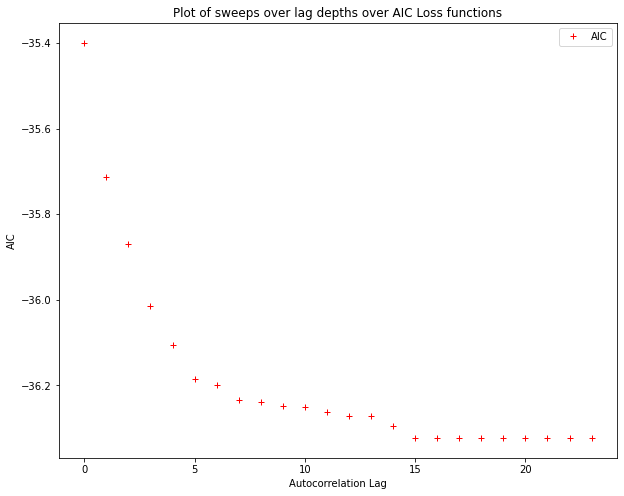

In [253]:
aic = []
for i in range(1,25):
    model = VAR(train)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss functions')
plt.show()

In [254]:
# aic = []
# for i in range(1,16):
#     model = VARMAX(endog=train.values,exog=states_train['RedemptionPriceError'].values,initialization='approximate_diffuse')
#     results = model.fit(order=(i,0))
#     aic.append(results.aic)
    
    
# plt.figure(figsize=(10, 8))
# plt.plot(aic, 'r+')
# plt.legend(['AIC'])
# plt.xlabel('Autocorrelation Lag')
# plt.ylabel('AIC')
# plt.title('Plot of sweeps over lag depths over AIC Loss functions')
# plt.show()

Given a set of candidate models for the data, **the preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting. In our case, this appears that a lag of ***15*** is optimal.


For a VARMAX model, which we have decided to use, an order of 1 is selected. To determine which model performs better overall for predictions, given the computational constraints that VARMAX is too slow to be retrained at each timestep, a [validation notebook](VAR_vs_VARMAX_evaluation.ipynb) was created to test if a VAR retrained every timestep vs a VARMAX retrained very 20 predictions. The result over 20 predictions was that VAR performed best for alpha, gamma, and delta but VARMAX performed better with beta by a higher magnitude than VAR. 

In [255]:
def VARMAX_prediction(e_u,RedemptionPriceError,newRedemptionPriceError,steps=1,lag=1):
    '''
    Description:
    Function to train and forecast a VARMAX model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    RedemptionPriceErrorPrevious: 1d Numpy array of RedemptionPriceError values
    newRedemptionPriceError: exogenous latest redemption price error signal - float
    steps: Number of forecast steps. Default is 1
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    Y_pred = VARMAX_prediction(train,states_train['RedemptionPriceError'],
                  states_test['RedemptionPriceError'][0:5],steps=5,lag=1)
    '''
    # instantiate the VARMAX model object from statsmodels 
    model = VARMAX(endog=e_u.values,exog=RedemptionPriceError,
                   initialization='approximate_diffuse',measurement_error=True)

    # fit model with determined lag values
    results = model.fit(order=(lag,0))
    
    Y_pred = results.forecast(steps = steps, exog=newRedemptionPriceError)
    
    return Y_pred.values

In [256]:
def VAR_prediction(e_u,lag=1):
    '''
    Description:
    Function to train and forecast a VAR model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    VAR_prediction(e_u,6)    
    '''
    # instantiate the VAR model object from statsmodels 
    model = VAR(e_u.values)

    # fit model with determined lag values
    results = model.fit(lag)
    
    lag_order = results.k_ar
    
    Y_pred = results.forecast(e_u.values[-lag_order:],1)

    
    return Y_pred[0]

In [257]:
Y_pred = VAR_prediction(e_u,15)

In [258]:
Y_pred

array([ 0.16565681,  1.44917535, -0.5428469 , -0.76672336])

In [262]:
def invert_power_transformation(pt,prediction):
    '''
    Definition:
    Function to invert power transformation
    
    Parameters:
    pt: transformation object
    prediction: Numpy array of model state coordinate transformed percentage changes
    
    Required:
    import pandas as pd
    from sklearn.preprocessing import PowerTransformer
    
    Returns:
    inverted transformation numpy array
    
    Example:
    inverted_array = invert_power_transformation(pt,prediction)
    
    '''
    # transform back into coordinate system
    inverted = pt.inverse_transform(prediction.reshape(1,-1))
    
    return inverted


Y_pred = invert_power_transformation(pt,Y_pred)
Y_pred

array([[ 1.77064141e-07,  6.89421294e-01, -4.08324517e-02,
        -5.29937035e-02]])

# New states

## Inverse Transformations

1. $d^* = \alpha * \bar{D}$

2. $q^* = C_0 * \bar{D} * \alpha + C_1 * \beta$.

3. $r^* = \gamma * {R_{RAI}}$

4. $z^* = \delta * {R_{ETH}}$

In [266]:
Y_pred[0][0]*params['debt_ceiling']

177.06414112694802

In [260]:
def inverse_transformation_and_state_update(Y_pred,previous_state,params):
    '''
    Description:
    Function to take system identification model prediction and invert transfrom and create new state
    
    Parameters:
    y_pred: numpy array of transformed state changes
    previous_state: pandas dataframe of previous state or 'current' state
    params: dictionary of system parameters
    
    Returns:
    pandas dataframe of new states 
    
    Example:
    inverse_transformation_and_state_update(Y_pred,previous_state,params)
    '''
    
    d_star = Y_pred[0] * params['debt_ceiling']
    
    q_star = previous_state['C_o'] * params['debt_ceiling'] * Y_pred[0] + previous_state['C_1'] * Y_pred[1]
    
    r_star = Y_pred[2] * previous_state['gamma'] * previous_state['RaiInUniswap']

    z_star = Y_pred[3] * previous_state['delta'] * previous_state['EthInUniswap']


    new_state = pd.DataFrame(previous_state[['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']].to_dict(),index=[0]) 
    new_state['Q'] = new_state['collateral'] + q_star
    new_state['D'] = new_state['RaiDrawnFromSAFEs'] + d_star
    new_state['R_Rai'] = new_state['RaiInUniswap'] + r_star
    new_state['R_Eth'] = new_state['EthInUniswap'] + z_star

    return new_state[['Q','D','R_Rai','R_Eth']]


In [267]:
previous_state = states.iloc[train.index[-1]]
print('Previous state:')
print(previous_state[['collateral','RaiDrawnFromSAFEs','RaiInUniswap','EthInUniswap']].to_dict())
print('\n New state:')
inverse_transformation_and_state_update(Y_pred[0],previous_state,params)

Previous state:
{'collateral': 6112.173200000001, 'RaiDrawnFromSAFEs': 33734228.66244739, 'RaiInUniswap': 29719802.479716294, 'EthInUniswap': 61661.21240037148}

 New state:


,Q,D,R_Rai,R_Eth
0,65234.627547,3.373441e+07,2.971693e+07,61653.03773


## Conclusion

In this notebook, we have iterated through several different models and decided on a VAR(15) model for us in the Rai Digital Twin.